In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies

In [2]:
# Tried a few things:
# More convolution layers did not increase accuracy
# BatchNorm helps the training initialy

In [1]:
from core_functions import SensorSignals
from networks import CNN_Simple, CNN_Dense

(1, 1, 1)
Normalizing dataset from [3.07030589] to
[1.]
Normalizing dataset from [3.07895111] to
[1.00281575]
Normalizing dataset from [3.07273222] to
[1.00079026]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7498, 1, 32)
Labels shape:  (7498,)
Unique labels:  [0 1 2]
Shape of test set: (1125, 1, 32)
Shape of train set: (5417, 1, 32)
Shape of validation set: (956, 1, 32)
Fraction of single class in test set:  0.32355555555555554


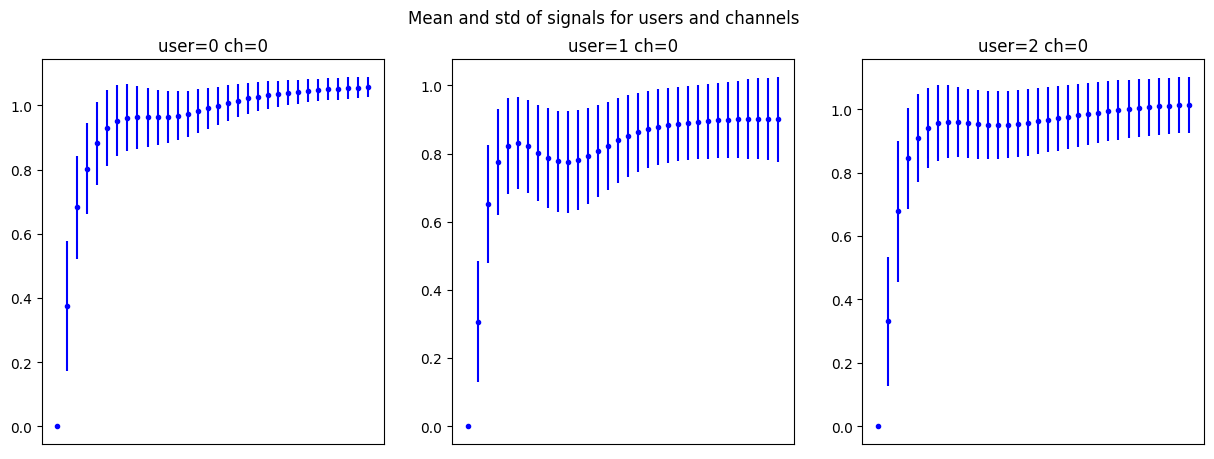

In [2]:
dataPath = "./second_collection_triggs_rels_32.npz"
S = SensorSignals(dataPath) 
S.split_data()
S.norm_X()
S.setup_tensors()
S.print_shapes()
S.plot_data()

In [3]:
# for CNN_STANDARD
# lr=5e-3, wd=1e-4
# with BatchNorm1d
# lr=1e-2, wd=1e-3

models = [CNN_Simple(input_ch=1, n_filters=8)]
S.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=256, max_epochs=50)

Epoch 1, Batch 1: loss_tr=1.309, loss_val=2.211, train=52.8%, val=50.9%
Epoch 2, Batch 1: loss_tr=0.604, loss_val=0.576, train=75.9%, val=75.6%
Epoch 3, Batch 1: loss_tr=0.424, loss_val=0.487, train=81.9%, val=81.0%
Epoch 4, Batch 1: loss_tr=0.439, loss_val=0.476, train=80.0%, val=79.2%
Epoch 5, Batch 1: loss_tr=0.325, loss_val=0.462, train=81.4%, val=80.4%
Epoch 6, Batch 1: loss_tr=0.339, loss_val=0.387, train=85.0%, val=83.8%
Epoch 7, Batch 1: loss_tr=0.335, loss_val=0.399, train=84.8%, val=84.6%
Epoch 8, Batch 1: loss_tr=0.261, loss_val=0.317, train=88.5%, val=88.2%
Epoch 9, Batch 1: loss_tr=0.233, loss_val=0.314, train=88.7%, val=88.5%
Epoch 10, Batch 1: loss_tr=0.330, loss_val=0.364, train=85.6%, val=85.3%
Epoch 11, Batch 1: loss_tr=0.260, loss_val=0.375, train=87.9%, val=86.4%
Epoch 12, Batch 1: loss_tr=0.270, loss_val=0.292, train=89.8%, val=90.0%
Epoch 13, Batch 1: loss_tr=0.356, loss_val=0.418, train=85.0%, val=84.0%
Epoch 14, Batch 1: loss_tr=0.338, loss_val=0.323, train=88.6

Accuracy of test set of best model (idx=0): 89.9%


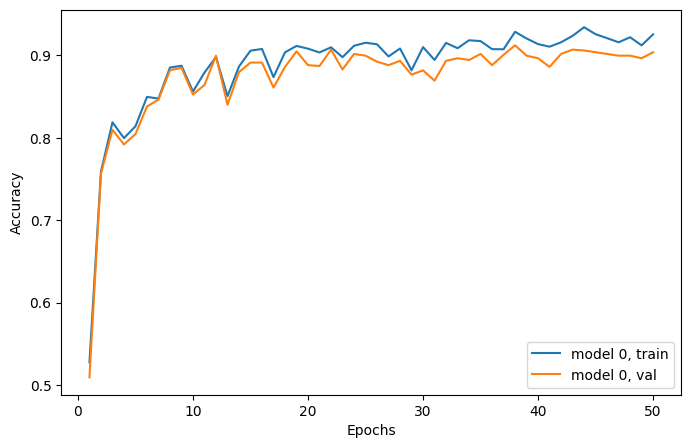

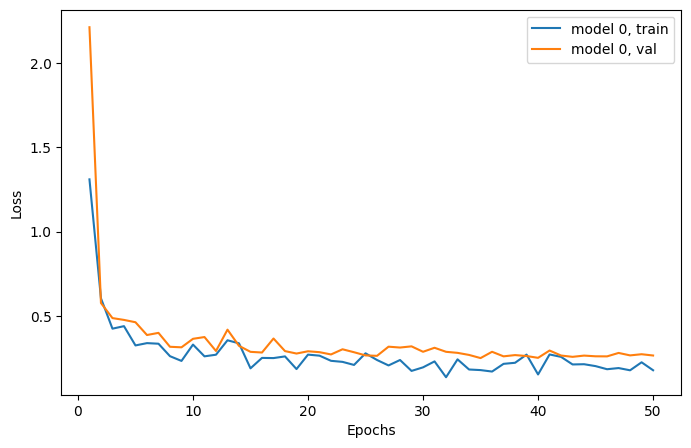

In [5]:
S.plot_train()
S.bestModelAcc()

(1, 1, 1)
Normalizing dataset from [3.07030589] to
[1.]
Normalizing dataset from [3.07895111] to
[1.00281575]
Normalizing dataset from [3.07273222] to
[1.00079026]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7498, 1, 32)
Labels shape:  (7498,)
Unique labels:  [0 1 2]
Shape of test set: (5625, 3, 32)
Shape of train set: (27085, 3, 32)
Shape of validation set: (4780, 3, 32)
Fraction of single class in test set:  0.32355555555555554


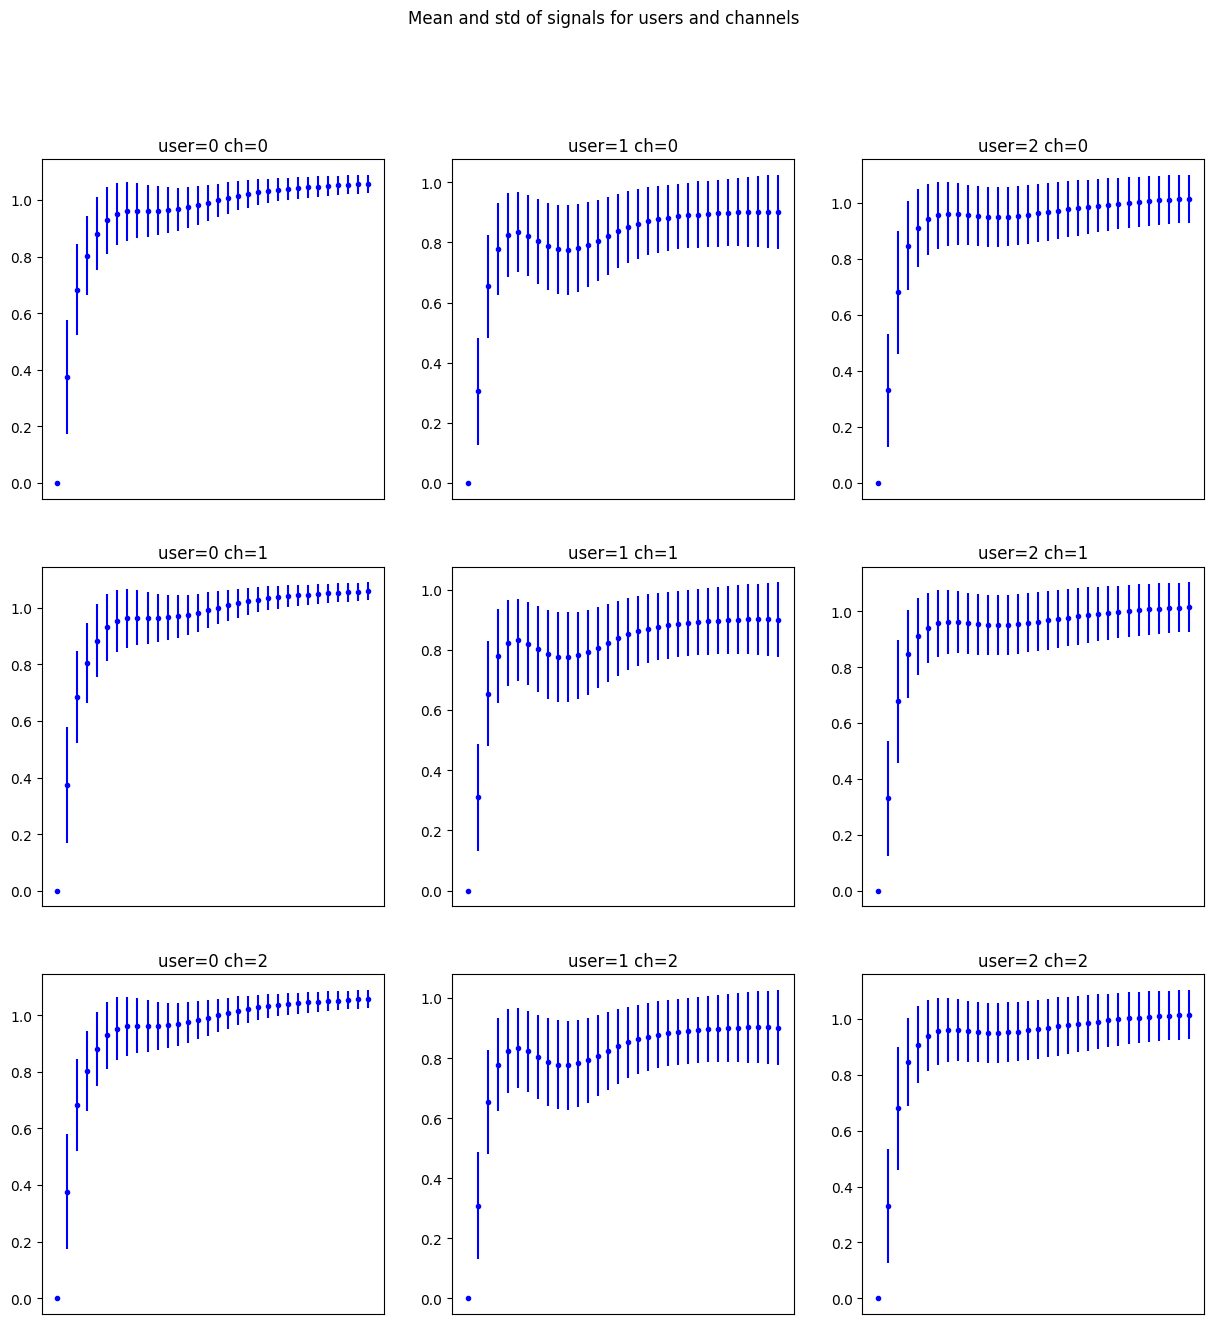

In [3]:
D = SensorSignals("./second_collection_triggs_rels_32.npz") 
D.split_data()
D.norm_X()
D.resample_channels()
D.setup_tensors()
D.print_shapes()
D.plot_data()

In [8]:
models = [CNN_Simple(input_ch=3, n_filters=16)]
D.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=128, max_epochs=5)

Epoch 1, Batch 1: loss=1.263, train=36.3%, val=35.4%
Epoch 1, Batch 101: loss=0.188, train=93.9%, val=92.6%
Epoch 1, Batch 201: loss=0.128, train=93.9%, val=93.3%
Epoch 2, Batch 1: loss=0.122, train=95.7%, val=95.1%
Epoch 2, Batch 101: loss=0.153, train=94.7%, val=94.5%
Epoch 2, Batch 201: loss=0.094, train=95.2%, val=94.3%
Epoch 3, Batch 1: loss=0.119, train=96.0%, val=95.3%
Epoch 3, Batch 101: loss=0.110, train=96.2%, val=95.6%
Epoch 3, Batch 201: loss=0.127, train=96.5%, val=95.8%
Epoch 4, Batch 1: loss=0.064, train=96.5%, val=95.4%
Epoch 4, Batch 101: loss=0.089, train=97.1%, val=96.4%
Epoch 4, Batch 201: loss=0.031, train=97.1%, val=96.5%
Epoch 5, Batch 1: loss=0.041, train=96.7%, val=95.5%
Epoch 5, Batch 101: loss=0.048, train=97.2%, val=96.4%
Epoch 5, Batch 201: loss=0.082, train=96.6%, val=95.6%
Training Complete!


Accuracy of test set of best model (idx=0): 96.9%


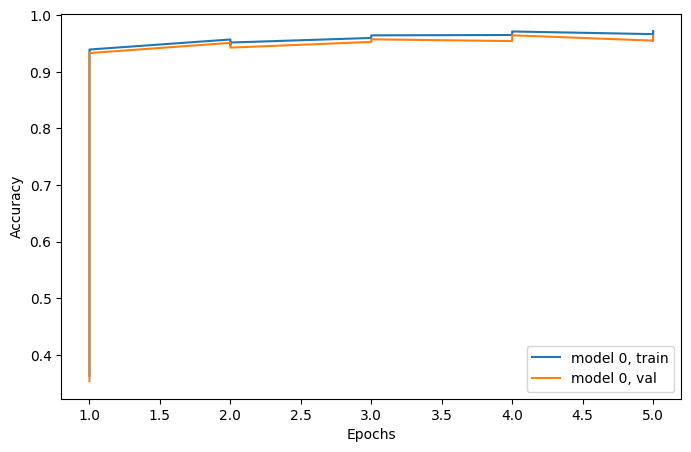

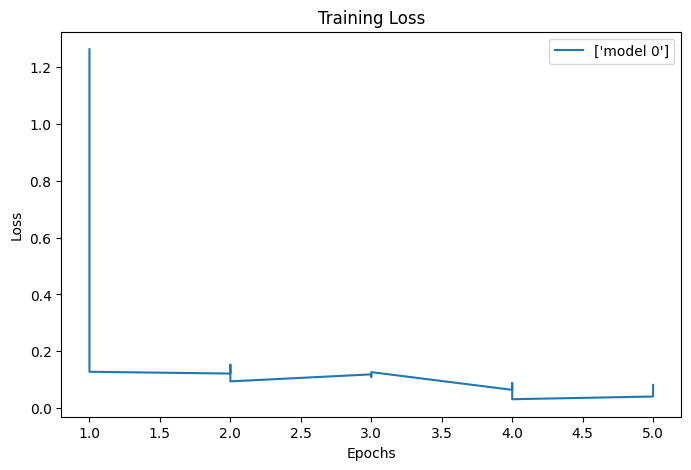

In [9]:
D.plot_train()
D.bestModelAcc()

(1, 2, 1)
Normalizing dataset from [3.07030589 1.42307107] to
[1. 1.]
Normalizing dataset from [3.07895111 1.42851733] to
[1.00281575 1.00382712]
Normalizing dataset from [3.07273222 1.43814017] to
[1.00079026 1.01058914]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7498, 2, 32)
Labels shape:  (7498,)
Unique labels:  [0 1 2]
Shape of test set: (1125, 2, 32)
Shape of train set: (5417, 2, 32)
Shape of validation set: (956, 2, 32)
Fraction of single class in test set:  0.32355555555555554
dtype of inputs:  torch.float32


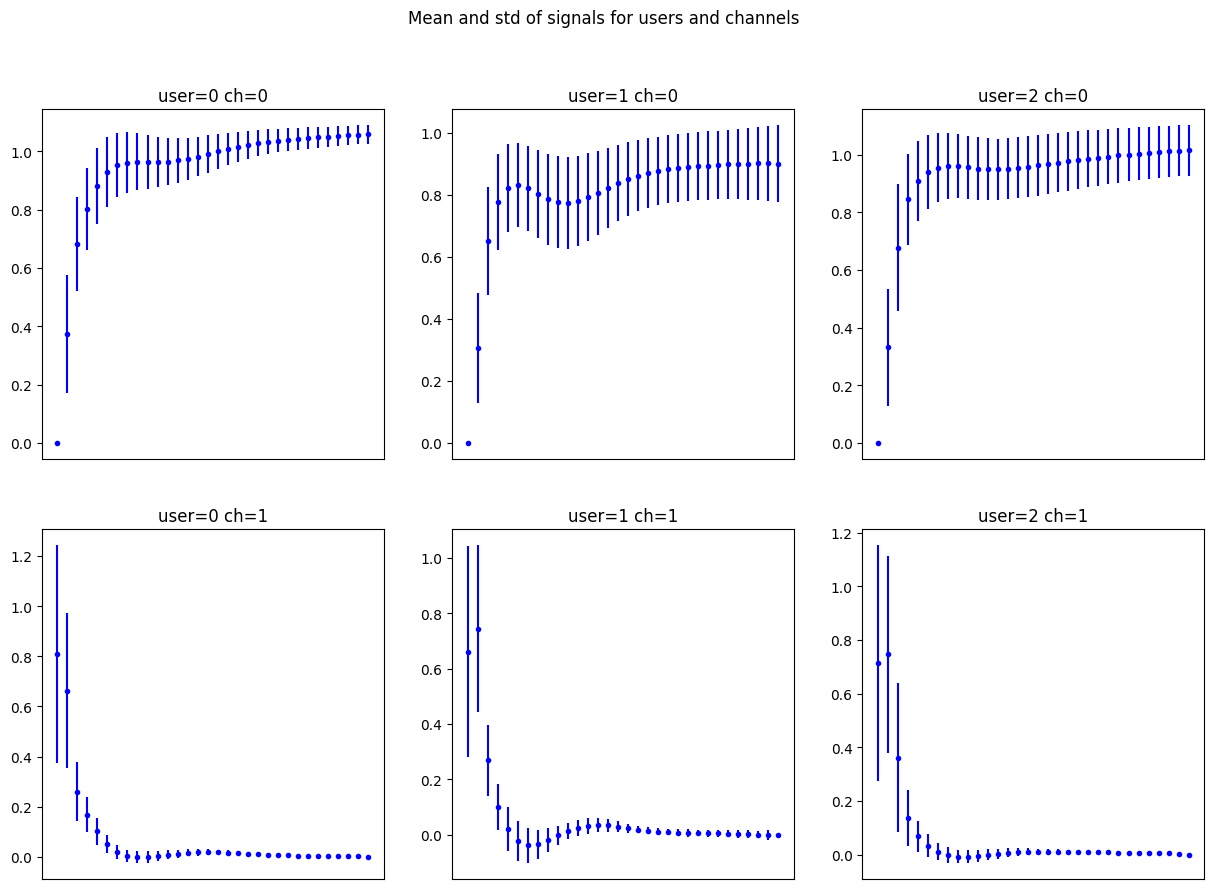

In [1]:
from core_functions import SensorSignals
from networks import CNN_Simple, CNN_Dense
# Look into using triggers and releases in two separate channels
E = SensorSignals("./second_collection_triggs_rels_32.npz", triggers=True, releases=False, transforms=True) 
E.split_data()
E.norm_X()
E.setup_tensors()
E.print_shapes()
E.plot_data()

In [2]:
models = [CNN_Dense(input_ch=2, n_filters=16)]
E.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=100)

Epoch 1, Batch 1: loss_tr=1.365, loss_val=5.375, train=42.6%, val=41.3%
Epoch 2, Batch 1: loss_tr=0.815, loss_val=0.797, train=63.8%, val=63.7%
Epoch 3, Batch 1: loss_tr=0.665, loss_val=0.694, train=69.9%, val=68.6%
Epoch 4, Batch 1: loss_tr=0.603, loss_val=0.577, train=75.1%, val=74.8%
Epoch 5, Batch 1: loss_tr=0.473, loss_val=0.475, train=79.9%, val=80.1%
Epoch 6, Batch 1: loss_tr=0.398, loss_val=0.478, train=80.4%, val=78.2%
Epoch 7, Batch 1: loss_tr=0.436, loss_val=0.411, train=83.4%, val=81.8%
Epoch 8, Batch 1: loss_tr=0.370, loss_val=0.375, train=86.7%, val=86.0%
Epoch 9, Batch 1: loss_tr=0.349, loss_val=0.384, train=86.0%, val=85.5%
Epoch 10, Batch 1: loss_tr=0.311, loss_val=0.341, train=86.8%, val=86.7%
Epoch 11, Batch 1: loss_tr=0.268, loss_val=0.317, train=88.2%, val=87.7%
Epoch 12, Batch 1: loss_tr=0.245, loss_val=0.314, train=88.3%, val=87.6%
Epoch 13, Batch 1: loss_tr=0.335, loss_val=0.367, train=87.0%, val=86.1%
Epoch 14, Batch 1: loss_tr=0.304, loss_val=0.326, train=89.1

Accuracy of test set of best model (idx=0): 90.1%


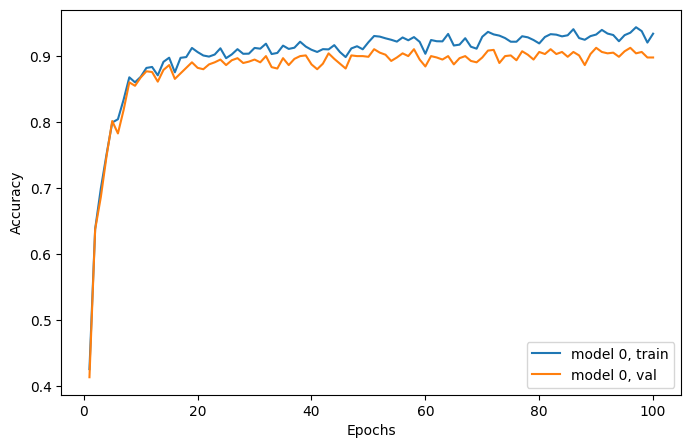

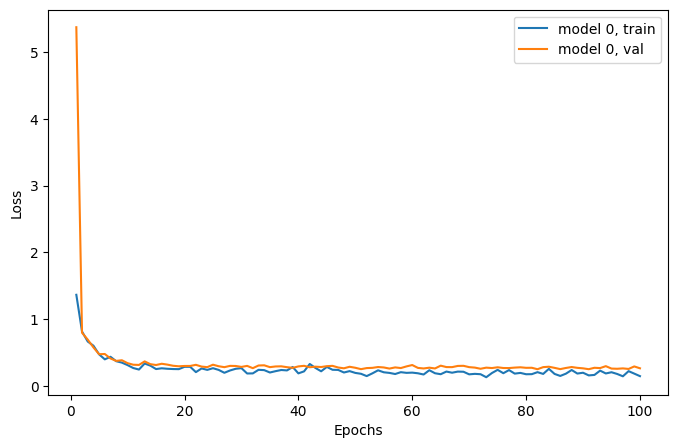

In [3]:
E.plot_train()
E.bestModelAcc()

In [1]:
# Longer intervals of time
from core_functions import SensorSignals
from networks import CNN_Simple, CNN_Dense

F = SensorSignals("./second_collection_zeros_out_long_data_1024.npz")
F.split_data()
F.norm_X()
F.setup_tensors()
F.print_shapes()

(1, 1, 1)
Normalizing dataset from [3.30166044] to
[1.]
Normalizing dataset from [3.30310387] to
[1.00043718]
Normalizing dataset from [3.29704658] to
[0.99860256]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (14312, 1, 1024)
Labels shape:  (14312,)
Unique labels:  [0 1 2]
Shape of test set: (2147, 1, 1024)
Shape of train set: (10340, 1, 1024)
Shape of validation set: (1825, 1, 1024)
Fraction of single class in test set:  0.34513274336283184
dtype of inputs:  torch.float32


In [4]:
models = [CNN_Simple(input_ch=1, n_filters=16)]
F.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=6*256, max_epochs=10)

Epoch 1, Batch 1: loss_tr=1.391, loss_val=111.106, train=44.2%, val=45.2%
Epoch 2, Batch 1: loss_tr=1.441, loss_val=1.090, train=49.3%, val=48.1%
Epoch 3, Batch 1: loss_tr=1.098, loss_val=1.098, train=33.2%, val=33.5%
Epoch 4, Batch 1: loss_tr=1.100, loss_val=1.098, train=33.4%, val=33.6%
Epoch 5, Batch 1: loss_tr=1.054, loss_val=0.993, train=46.5%, val=47.8%
Epoch 6, Batch 1: loss_tr=0.912, loss_val=0.889, train=50.5%, val=50.3%
Epoch 7, Batch 1: loss_tr=0.729, loss_val=0.739, train=66.6%, val=65.0%
Epoch 8, Batch 1: loss_tr=0.717, loss_val=0.708, train=67.5%, val=64.3%
Epoch 9, Batch 1: loss_tr=0.628, loss_val=0.762, train=62.9%, val=62.2%
Epoch 10, Batch 1: loss_tr=0.655, loss_val=0.688, train=68.5%, val=66.0%
Training Complete!


Accuracy of test set of best model (idx=0): 70.6%


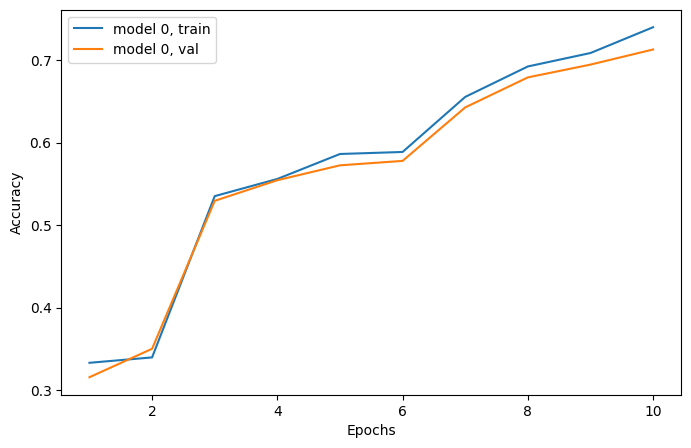

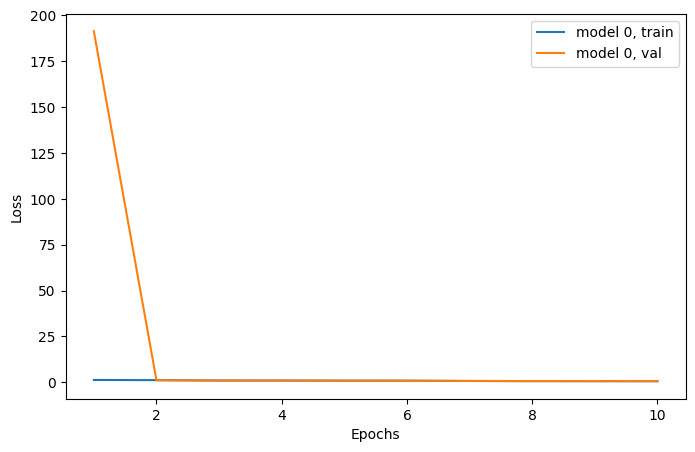

In [14]:
F.plot_train()
F.bestModelAcc()